# Rapport

ETAPES:

a)Partie analyse lineaire:

    1-discrétisation de la structure 
    2-création des matrices K  et F
    3-mise en place des conditions aux limites
    4-resolution de K*U=F => obtention de U

b)Partie analyse du flambage 

    1-construction de la matrice G
    2-resolution de l'equation (K-lambda*G)*U=0 grace à la méthode puissance itérée 
    => obtention de lambda
    3-Vérification de notre coefficient lambda

Dans un premier temps, on a créé un modèle de notre structure en la discrétisant.

Nous avons par un cas simple, soit une poutre.
    
Nous avons décomposé une poutre en $n_{e}$ segments. Elle est constituée d'**éléments**, separés par $n$ **noeuds** avec pour coordonnées $\{(x_I,y_I)\}_{I=1}^{n}$.

Nous avons ensuite appliqué cette discrétisation à une structure plus complexe, le portique.

# I-Partie analyse du flambement de structure

## 1) Construction de la matrice G

In [1]:
%matplotlib inline  
from sympy.interactive import printing
printing.init_printing()
from frame import *
import sympy as sp
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg

Après avoir trouvé la **solution fondamentale** du problème, nous avons commencé la résolution du problème de flambement de notre structure.

La résolution de ce problème consiste à trouver le coefficient multiplicateur de charges, $\lambda$.

Pour cela, on doit résoudre le problème :
$$
(K-\lambda G)U = 0
$$

avec $G$ la **matrice de rigidité géométrique**

On construit $G$ à l'aide la formule suivante: 
$$
G^{(e)}_{ij}=-\bar N_0^{(e)}\int_0^LS_{1i}'(s)S_{1j}'(s) ds,\quad i,j=1,\ldots,6 
$$
avec $N_0^{(e)}$ la valeur normale de l'effort pour un élément $e$

Nous avons, tout d'abord, récupéré les valeurs des efforts normaux pour chaque élément puis nous les avons mis dans un tableau.

In [2]:
class Frame_Buckling1(LinearFrame):

    def N_local_stress(self,element):

        """
        Returns the normal force of an element.
        """
        Ke= self.K_local()
        Ue= self.U_e_local_coord(element)
        F=Ke*Ue
        N_local = F[3]
        return N_local
    
    def N_local_stress_tot(self):

        """
        Returns the normal force of all elements.
        """
        Ns=[self.N_local_stress(e)for e in range (self.nelements)]
        return Ns
    
    

Nous avons utilisé le principe d'héritage pour créer cette classe. En effet, cette classe dépend de la classe utilisée précédemment, $LinearFrame$.

Après avoir récupéré l'effort normal pour chaque élément $e$, nous avons codé 3 méthodes pour obtenir la matrice G. 
La première méthode transcrit l'expression de G écrite au-dessus en code, la deuxième fait que G va être exprimé dans le repère global et la dernière méthode assemble le tout pour donner la matrice globale G de notre strucutre.

In [3]:
class Frame_Buckling2(Frame_Buckling1):
    def G_local(self):
        """
        Returns the local geometric stiffness matrix
        """
        L = sp.Symbol('L')
        s = sp.Symbol('s')
        S=self.S()
        Ge=sp.Matrix([[sp.integrate(S[1,i_local].diff(s)*S[1,j_local].diff(s),(s,0,L) )for i_local in range(6)] for j_local in range(6)]) 
        return Ge
    
    def G_local_rotated(self):
        """
        Gives the analytical expression of the local geometric stiffness matrix in the global coordinate system 
        as a function of the orientation angle alpha
        """
        alpha = sp.Symbol("alpha")
        R = self.rotation_matrix(alpha)
        Ge = R.transpose()*self.G_local()*R
        return Ge
    
    def assemble_G(self):
        """
        Returns the global geometric stiffness matrix
        """
        Ge = self.G_local_rotated()
        G = np.zeros([self.ndof,self.ndof])
        N0=self.N_local_stress_tot()
        for e in range(self.nelements):
            Gen = -N0[e].subs({'EI': self.EI[e], 'ES': self.ES[e], 'L': self.Ls[e], 'alpha': self.angles[e]})*Ge.subs({'EI': self.EI[e], 'ES': self.ES[e], 'L': self.Ls[e], 'alpha': self.angles[e]})
            for i_local in range(6):
                for j_local in range(6):
                    G[self.dof_map(e, i_local),self.dof_map(e, j_local)] += Gen[i_local,j_local]
        return G
    
    

 Nous appliquons ensuite à la matrice G les conditions de bords. Nous avons réutilisé le même principe que pour K.

In [4]:
class Frame_Buckling(Frame_Buckling2):
    def bc_apply_G(self,G,blocked_dof):
        for (dof) in enumerate(blocked_dof): 
            Gbc = G 
            Gbc[dof, :] = 0
            Gbc[:, dof] = 0
            Gbc[dof, dof] = 1
        return Gbc

## 2)Validation du modèle numérique

Après avoir créer toutes ces méthodes, nous les avons testé sur un cas simple où nous pouvions comparer le modèle numérique et le modèle théorique, nous avons pour cela choisi la poutre en encastrement d'un côté et en appui simple glissant de l'autre soumise à une force de 1N suivant x.

Vous trouverez ci-dessous l'analyse linéaire :

Frame with
10 elements
11 nodes
33 dofs


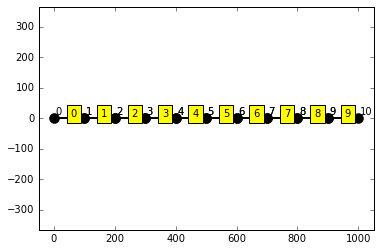

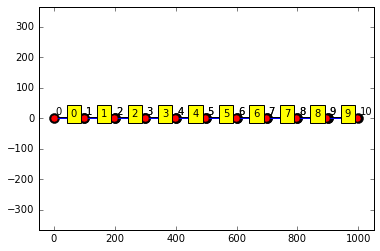

In [5]:
E=1.3 #en MPa
h=7.5 #en mm
b=20. #en mm
I=b*(h**3)/12 #en mm^4
S=b*h  #en mm^2

n_elements = 10
xnodes = np.linspace(0,1000,n_elements + 1)
ynodes = np.linspace(0,0,n_elements + 1)
nodes = np.array([xnodes,ynodes]).transpose()
n_nodes = xnodes.size
elements=np.array([[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9],[9,10]])

frame= Frame_Buckling(nodes,elements)
frame.plot_with_label()

ne = frame.nelements
ndof = frame.ndof
EI = np.ones(ne)*E*I
ES = np.ones(ne)*E*S
f_x = 0*np.ones(ne)
f_y = 0*np.ones(ne)
frame.set_distributed_loads(f_x, f_y)
frame.set_stiffness(EI, ES)
blocked_dof = np.array([0, 1, ndof-2])
bc_values = np.array([0, 0, 0])

K = frame.assemble_K()
F=frame.assemble_F()
#F[12]=F[12]-.5*EI[0]*np.pi**2
F[ndof-3]=F[ndof-3]-1.
Kbc, Fbc = frame.bc_apply(K, F, blocked_dof, bc_values)
Usol = np.linalg.solve(Kbc,Fbc)

frame.set_displacement(Usol)
frame.plot_with_label()
frame.plot_displaced()

Voici l'analyse du flambement de cette structure :

In [6]:
Gbc=frame.assemble_G()
G=frame.bc_apply_G(Gbc,blocked_dof)

Nous avons appris lors de ces séances de projet que pour résoudre le problème $(K-\lambda G)U = 0$ il fallait obtenir les valeurs propres de la matrice $G^{-1}K$. Nous avons pour cela deux méthodes de résolution numériques, la méthode la puissance itérée et l'algorithme QR. Or, dans notre cas, la matrice G est singulière. Il nous est donc impossible de calculer un inverse. 

Pour contourner ce problème, nous avons utilisé la bibliothèque sparse présente dans scipy.
Dans cette bibliothèque, il y a une fonction qui permet d'avoir les valeurs propres à partir d'une certaine sans sprendre en compte le caractère singulier de G.

Voici la résolution du problème aux valeurs propres:

[  8.77865919e-03   4.50557314e+00   5.08998538e+00   5.43777076e+00
   3.74556940e+01]


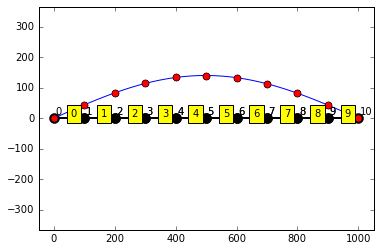

In [7]:
Ks = sparse.csr_matrix(K)
Gs = sparse.csr_matrix(G)
val, vect = linalg.eigsh(Ks, 5, Gs, which = 'LA', sigma =4.)
print(val)
frame.set_displacement(10*vect[:,0])
frame.plot_with_label()
frame.plot_displaced()

Comme vous pouvez le constatez, la première valeur propre obtenue correspond aussi au premier coefficient multiplicateur de charges, $\lambda_{1}$. On a donc $\lambda_{1num}=8,7.10^{-3}$

Nous avons utilisé ce que nous avons vu en cours pour calculer la valeur théorique de $\lambda$ en utilisant les mêmes conditions que pour le modèle numérique.

In [8]:
E*I*np.pi**2/1000**2

Nous avons obtenu que $\lambda_{1théo}=9.10^{-3}$.

Nous avons pu constater que notre valeur théorique et notre valeur numérique était semblable aux approximations près. Nous pouvons donc conclure que notre modèle numérique est bon et qu'il peut être utilisé pour calculer les structures qui nous intéressse.

## 3)Comparaison de notre modèle numérique avec notre modèle expérimentale

Après avoir validé notre modèle numérique, nous l'avons appliqué aux deux structures de l'exercice 2, soit le portique et le portique renforcé. Voici la discrétisation du problème :

Frame with
7 elements
7 nodes
21 dofs


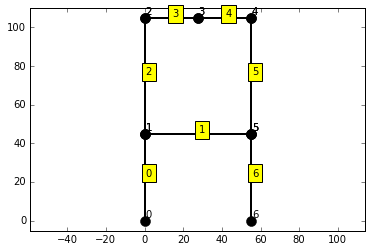

In [9]:
Lx=55. #en mm
Lyh=60. #en mm
Lyb=45. #en mm
nodes= np.array([[0.,0.],[0.,Lyb],[0.,Lyh+Lyb],[Lx/2,Lyh+Lyb],[Lx,Lyh+Lyb],[Lx,Lyb],[Lx,0.]])
elements=np.array([[0,1],[1,5],[1,2],[2,3],[3,4],[4,5],[5,6]])

frame= Frame_Buckling(nodes,elements)
frame.plot_with_label()

Pour le portique renforcé, nous avons appliqué une force de $1N$ au noeud 3 en y  et nous avons modifié le module de Young E des éléments 1,3 et 4 en le multipliant par 100.

Pour le portique, nous avons appliqué deux forces de $1N$ au noeud 2 et 4 en y. 

Nous avons utilisé ensuite le même principe de résolution que pour le 2).

Pour le portique renforcé, nous avons obtenu un $\lambda_{num1}=4,0$.

Pour le portique, nous avons obtenu un $\lambda_{num2}=1,8$.

Dans les conditions prises pour le portique renforcé, il faudrait 400g au niveau du noeud 3 pour que la structure flambe.

Dans les conditions prises pour le portique, il faudrait 180g au niveau des noeuds 2 et 4  pour que la structure flambe.




Nous avons testé expérimentalement sur le portique et le portique pour voir si nos modèles numériques sont une modélisation acceptable de notre structure.

Voici la photo pour le portique renforcé, nous avons mis une masse totale de 400g au dessus de notre structure qui corresponderait à notre noeud 3 sur notre modélisation :

![image](photo/flambement portique r mee.png)

Pour vérifier le flambement de notre structure, nous avons appuyé doucement sur le côté de la structure et nous avons remarqué qu'il y avait un grand déplacement de notre structure ce qui n'était pas le cas quand nous mettions pas de masse.

Nous avons obtenu $\lambda_{exp1}=4,0$ pour le portique renforcé.

Nous avons fait de même pour le portique et nous avons trouvé $\lambda_{exp2}=1,7$.

Nous trouvons donc des valeurs valeurs proches entre notre modèle numérique avec $\lambda_{num1}=4,0$ et $\lambda_{num2}=1,8$ ,et notre modèle expérimental avec $\lambda_{exp1}=4,0$ et $\lambda_{exp2}=1,7$.

# Conclusion

Pour conclure, nous avons pu comparer nos modèles expérimentaux et nos modèles numériques et voir qu'ils se comportaient de la même façon même si les mesures sur les modèles expérimentaux restent très approximatives.
Les approximations faites dans notre modèle numérique ne sont donc pas aberrantes.

Nous avons par la suite essayé notre modélisation numérique sur d'autres structures afin de savoir laquelle pouvait supporter un $\lambda$ maximal et nous sommes arrivés à la structure ci-dessous qui flambe à $\lambda=20$ soit 2kg.Cette disposition serait la disposition optimale pour maximiser le $\lambda$ de notre modélisation d'un immeuble à deux étages.

Frame with
9 elements
7 nodes
21 dofs


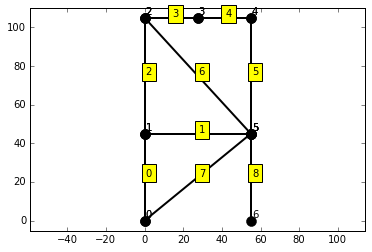

In [10]:
nodes= np.array([[0.,0.],[0.,Lyb],[0.,Lyh+Lyb],[Lx/2,Lyh+Lyb],[Lx,Lyh+Lyb],[Lx,Lyb],[Lx,0.]])
elements=np.array([[0,1],[1,5],[1,2],[2,3],[3,4],[4,5],[2,5],[0,5],[5,6]])

frame= Frame_Buckling(nodes,elements)
frame.plot_with_label()